# Image classification

## Import TensorFlow and other libraries

In [1]:
#matplotlib is used to transforman data and plot it visually.
import matplotlib.pyplot as plt

#numpy is a math library for handling mathy matricies
import numpy as np

#os is used for accessing the local computer system
import os

#image library used to handle images
import PIL

#opencv library is great for computer vision, we use it to easily access webcameras
import cv2

#libraries for ev3dev robot
import rpyc

#handy libraries
import time
import random

#tensorflow is our machine learning library that provides a way to create, edit, save, load our models.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

##### Show Tensorflow version

In [2]:
print(tf.__version__)

2.4.1


## Create a dataset

Define some parameters for the loader:

In [3]:
data_dir = "C:/Users/MLSE IT HELPDESK/Desktop/OMARADEV/AI/EC_DATASET"
batch_size = 16
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 782 files belonging to 5 classes.
Using 626 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 782 files belonging to 5 classes.
Using 156 files for validation.


## Our Dataset is made up of

In [6]:
class_names = train_ds.class_names
print(class_names)

['CAPACITOR', 'IC', 'POTENTIOMETER', 'RESISTOR', 'SCREW']


## Visualize the data

Here are 9 images from the training dataset.

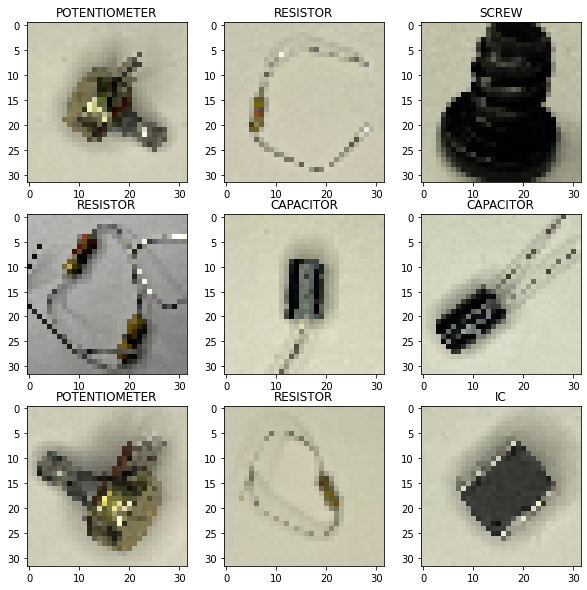

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("on")

You will train a model using these datasets by passing them to `model.fit` in a moment. 

## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.


In [9]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.20,0.20),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

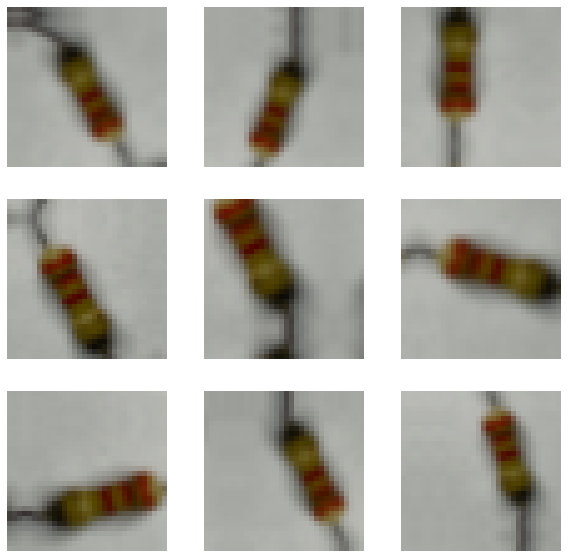

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [11]:
num_classes = 5
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)         

In [20]:
epochs = 80
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/200
40/40 [==============================] - 1s 31ms/step - loss: 0.2242 - accuracy: 0.9058 - val_loss: 0.4379 - val_accuracy: 0.8205
Epoch 2/200
40/40 [==============================] - 1s 34ms/step - loss: 0.1594 - accuracy: 0.9521 - val_loss: 0.4540 - val_accuracy: 0.8462
Epoch 3/200
40/40 [==============================] - 1s 33ms/step - loss: 0.1598 - accuracy: 0.9377 - val_loss: 0.3316 - val_accuracy: 0.8782
Epoch 4/200
40/40 [==============================] - 1s 29ms/step - loss: 0.1652 - accuracy: 0.9409 - val_loss: 0.2695 - val_accuracy: 0.8846
Epoch 5/200
40/40 [==============================] - 1s 29ms/step - loss: 0.1546 - accuracy: 0.9345 - val_loss: 0.6529 - val_accuracy: 0.7692
Epoch 6/200
40/40 [==============================] - 1s 30ms/step - loss: 0.2008 - accuracy: 0.9249 - val_loss: 0.3134 - val_accuracy: 0.8718
Epoch 7/200
40/40 [==============================] - 1s 29ms/step - loss: 0.1801 - accuracy: 0.9313 - val_loss: 0.4122 - val_accuracy: 0.8654
Epoch 

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

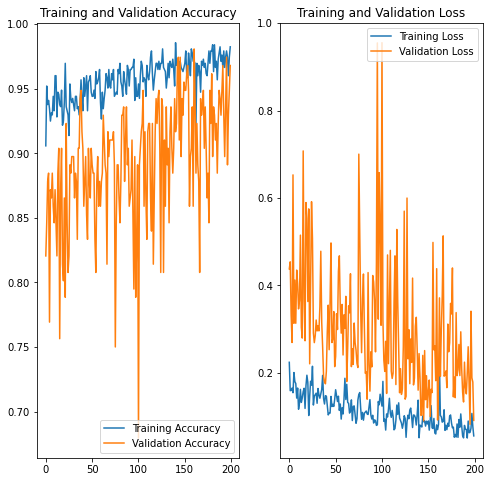

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Read from web camera

In [16]:
cap = cv2.VideoCapture(1) # video capture source camera
time.sleep(1)
ret,frame = cap.read() # return a single frame in variable `frame`
y=150
x=200
h=200
w=200
crop = frame[y:y+h, x:x+w]
cv2.imwrite('CLASSIFY/camera.png',crop)
cap.release()
time.sleep(1)
#test_image = cv2.imread('trick.png')
#test_image = cv2.resize(test_image, (64, 64))
#test_image = (test_image[...,::-1].astype(np.float32)) / 255.0

## Predict on new data

Here we'll load an image that was not included in the original training or validation data.

This image most likely belongs to CAPACITOR with a 99.78 percent confidence.


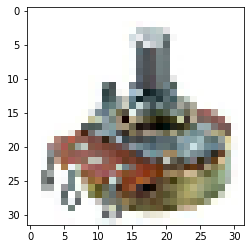

In [27]:
#classify_image = "C:/Users/MLSE IT HELPDESK/Desktop/OMARADEV/AI/CLASSIFY/camera.png"
classify_image = "C:/Users/MLSE IT HELPDESK/Desktop/OMARADEV/AI/CLASSIFY/test-07.jpg"

img = keras.preprocessing.image.load_img(
    classify_image, target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

img_array = []
plt.imshow(img)

results = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
print(
    results
)

## load the robot

In [18]:
## ssh(putty) into e3dev brick run -> /usr/bin/rpyc_classic.py --host 169.254.29.3

## don't forget to update this ip too.
conn = rpyc.classic.connect('169.254.29.3')
ev3dev2_motor = conn.modules['ev3dev2.motor']
ev3dev2_sensor = conn.modules['ev3dev2.sensor']
ev3dev2_sensor_lego = conn.modules['ev3dev2.sensor.lego']
ev3dev2_sound = conn.modules['ev3dev2.sound']

# Load inputs and outputs
motor = ev3dev2_motor.LargeMotor(ev3dev2_motor.OUTPUT_A)
ts = ev3dev2_sensor_lego.TouchSensor(ev3dev2_sensor.INPUT_1)
sound = ev3dev2_sound.Sound()

OSError: [WinError 10065] A socket operation was attempted to an unreachable host

In [ ]:
sound.speak('Push the button, to scan.')
while True:
    ts.wait_for_pressed()
    cap = cv2.VideoCapture(1) # video capture source camera
    time.sleep(1)
    ret,frame = cap.read() # return a single frame in variable `frame`
    y=150
    x=200
    h=200
    w=200
    crop = frame[y:y+h, x:x+w]
    cv2.imwrite('CLASSIFY/camera.png',crop)
    cap.release()
    time.sleep(1)
    classify_image = "C:/Users/MLSE IT HELPDESK/Desktop/OMARADEV/AI/CLASSIFY/camera.png"

    ##convert classify image to be able to predict
    img = keras.preprocessing.image.load_img(
        classify_image, target_size=(img_height, img_width)
    )

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    results = "This most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
    sound.speak(results) 
    motor.run_forever(speed_sp=50)
    time.sleep(5)
    motor.stop()